# Pollen Classification with MSDNET

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
import tensorflow.keras as keras

## Global Constants

In [2]:
BASE_PATH = os.path.join(os.getcwd(), 'train', 'images')
PATHS = []
for i in range(1, 5):
    folder = os.path.join(BASE_PATH, str(i), 'train_OBJ')
    PATHS.append([folder + os.sep + '{0}'.format(name) for name in os.listdir(folder)])
IMGS_PER_CLASS = 10000

## Read in the Pollen Images

In [3]:
X = []
y = []
for i in range(0, 4):
    for path in PATHS[i]:
        img = cv2.imread(path)
        if img is not None:
            X.append(cv2.imread(path))
            y.append(i)
X = np.array(X, dtype=np.float32) / 255
y = np.array(y)

## Split into Train and Test Sets

In [4]:
# Split entire dataset into a train and test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [5]:
# weigh each class with the complement of the frequency of each class during training to improve 
# training for underrepresented classes

print('Training Set Class Distribution:')
print(pd.Series(y_train).value_counts() / y_train.shape[0], '\n')
print('Test Set Class Distribution:')
print(pd.Series(y_test).value_counts() / y_test.shape[0])

class_weights = (1 - (pd.Series(y_train).value_counts() / y_train.shape[0])).to_dict()

Training Set Class Distribution:
2    0.728401
0    0.138804
1    0.068565
3    0.064230
dtype: float64 

Test Set Class Distribution:
2    0.728723
0    0.139184
1    0.068262
3    0.063830
dtype: float64


## Augment Training Data

In [6]:
def augment_images(X, num_imgs=0):  
    preprocessing = keras.layers.experimental.preprocessing  
    data_augmentation = keras.Sequential([
        preprocessing.RandomFlip(mode='horizontal_and_vertical'),
        preprocessing.RandomRotation(factor=0.75, fill_mode='reflect', seed=42),
        preprocessing.RandomZoom(height_factor=0.75, width_factor=0.75,
                                 fill_mode='reflect', seed=42),
        preprocessing.RandomTranslation(height_factor=0.75, width_factor=0.75,
                                        fill_mode='reflect', seed=42),
        preprocessing.RandomContrast(factor=0.9, seed=42) 
    ])
    random_indices = np.random.randint(0, len(X), num_imgs)
    return data_augmentation(X[random_indices])
   
for i in range(0, 4):
    class_indices = np.where(y_train == i)
    num_imgs = max(IMGS_PER_CLASS - len(class_indices[0]), 0)
    X_train = np.concatenate((X_train, augment_images(X_train[class_indices], num_imgs=num_imgs)), 
                             axis=0)
    y_train = np.concatenate((y_train, np.repeat(i, num_imgs)), axis=0)

## Check Out Random Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)


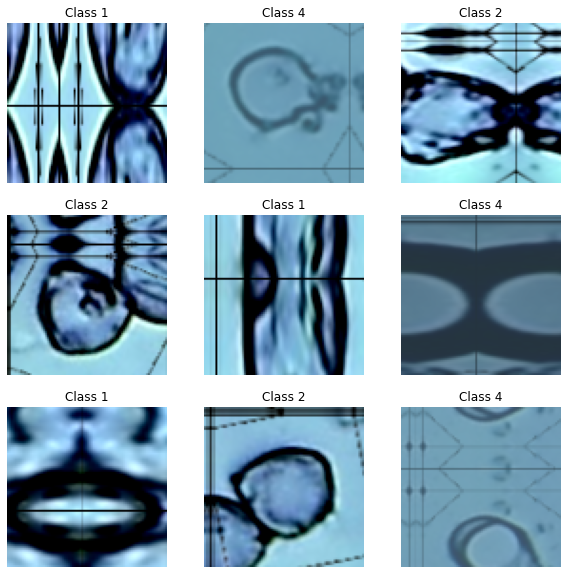

In [7]:
plt.figure(figsize=(10,10))
for i in range(0,9):
    j = np.random.randint(low=0, high=X_train.shape[0])
    img = X_train[j]
    print(img.shape)
    ax = plt.subplot(3,3,i+1, title='Class ' + str(y_train[j] + 1))
    plt.imshow(img)
    plt.axis('off')

## Split Train Set into Train and Validation Sets

In [8]:
# Split the train set further into a train and validation set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
for train_index, valid_index in split.split(X_train, y_train):
    X_train, X_valid = X_train[train_index], X_train[valid_index]
    y_train, y_valid = y_train[train_index], y_train[valid_index]

## Build MSDNet Using Keras

In [9]:
input_layer = keras.Input(shape=X_train[0].shape)
hidden_1 = keras.layers.Conv2D(filters=4, kernel_size=(5,5), strides=1, 
                               dilation_rate=1, padding='same', 
                               activation=keras.activations.relu,
                               kernel_regularizer=keras.regularizers.L1L2(l1=0.06, l2=0.06))(input_layer)
concat_1 = keras.layers.Concatenate()([input_layer, hidden_1])
hidden_2 = keras.layers.Conv2D(filters=4, kernel_size=(5,5), strides=1, 
                               dilation_rate=3, padding='same', 
                               activation=keras.activations.relu,
                               kernel_regularizer=keras.regularizers.L1L2(l1=0.12, l2=0.12))(concat_1)
concat_2 = keras.layers.Concatenate()([input_layer, hidden_1, hidden_2])
hidden_3 = keras.layers.Conv2D(filters=4, kernel_size=(5,5), strides=1,
                               dilation_rate=5, padding='same', 
                               activation=keras.activations.relu,
                               kernel_regularizer=keras.regularizers.L1L2(l1=0.24, l2=0.24))(concat_2)
concat_3 = keras.layers.Concatenate()([input_layer, hidden_1, hidden_2, hidden_3])
hidden_4 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), strides=1,
                               dilation_rate=5, padding='same', 
                               activation=keras.activations.relu,
                               kernel_regularizer=keras.regularizers.L1L2(l1=0.12, l2=0.12))(concat_3)
concat_4 = keras.layers.Concatenate()([input_layer, hidden_1, hidden_2, hidden_3, hidden_4])
hidden_5 = keras.layers.Conv2D(filters=4, kernel_size=(3,3), strides=1,
                               dilation_rate=6, padding='same', 
                               activation=keras.activations.relu)(concat_4)
concat_5 = keras.layers.Concatenate()([input_layer, hidden_1, hidden_2, hidden_3, hidden_4, hidden_5])
hidden_6 = keras.layers.Flatten()(concat_5)
output_layer = keras.layers.Dense(units=4, activation=keras.activations.softmax)(hidden_6)
model = keras.Model(inputs=[input_layer], outputs=[output_layer])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 84, 84, 4)    304         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 84, 84, 7)    0           input_1[0][0]                    
                                                                 conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 84, 84, 4)    704         concatenate[0][0]     

## Train First on CIFAR-10 Dataset

In [13]:
# Get the data
# Train Model On it
# Freeze layers
# Train again on Pollen

In [10]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [11]:
history = model.fit(x=np.asarray(X_train)[:], y=y_train, epochs = 30, batch_size=16,
          callbacks=[keras.callbacks.ModelCheckpoint('model_checkpoint.h5')],
          validation_data=(X_valid, y_valid))

Epoch 1/30
2250/2250 [==============================] - 820s 364ms/step - loss: 3.3386 - accuracy: 0.6503 - val_loss: 1.3985 - val_accuracy: 0.7212
Epoch 2/30
2250/2250 [==============================] - 787s 350ms/step - loss: 1.3427 - accuracy: 0.7128 - val_loss: 1.2067 - val_accuracy: 0.7347
Epoch 3/30
2250/2250 [==============================] - 1163s 517ms/step - loss: 1.3358 - accuracy: 0.7366 - val_loss: 2.7018 - val_accuracy: 0.6765
Epoch 4/30
2250/2250 [==============================] - 1071s 476ms/step - loss: 1.2968 - accuracy: 0.7597 - val_loss: 1.7701 - val_accuracy: 0.6697
Epoch 5/30
2250/2250 [==============================] - 1105s 491ms/step - loss: 1.2136 - accuracy: 0.7755 - val_loss: 1.1132 - val_accuracy: 0.7565
Epoch 6/30
2250/2250 [==============================] - 1109s 493ms/step - loss: 1.2375 - accuracy: 0.7880 - val_loss: 2.0517 - val_accuracy: 0.6565
Epoch 7/30
2250/2250 [==============================] - 931s 414ms/step - loss: 1.1462 - accuracy: 0.8016 - 

KeyboardInterrupt: 

In [ ]:
history.history.pop('loss', None)
history.history.pop('val_loss', None)
pd.DataFrame(history.history).plot()
plt.gca().set_ylim(0,1)

In [12]:
print(model.evaluate(X_test, y_test))

250/250 [==============================] - 19s 75ms/step - loss: 1.2843 - accuracy: 0.8052
[1.2842700481414795, 0.8052499890327454]
